# Tree Based Modelling

## $\textbf{1. Imports}$

$\textbf{Import Libraries}$

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from itertools import combinations
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, f1_score
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

$\textbf{Import Data}$

In [2]:
def load_dataframes(imputed_file_path, daily_file_path):
    imputed_df = pd.read_csv(imputed_file_path)
    daily_df = pd.read_csv(daily_file_path)
    return imputed_df, daily_df

In [3]:
imputed_file_path = '..\\data\\interim\\imputed_data.csv'
daily_file_path = '..\\data\\interim\\daily_averaged_data.csv'
imputed_df, daily_df = load_dataframes(imputed_file_path, daily_file_path)

In [4]:
imputed_df.head()

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
0,0,2020-01-10 00:00:00,31.083333,58.916667,599.000000,211.0,118.000000,247.000000,277.333333,2.083333,0
1,0,2020-01-10 01:00:00,31.000000,59.000000,598.500000,204.0,118.000000,247.000000,277.416667,2.250000,0
2,0,2020-01-10 02:00:00,30.916667,59.000000,598.416667,197.0,118.000000,247.000000,277.416667,2.000000,0
3,0,2020-01-10 03:00:00,31.000000,58.909091,597.181818,197.0,119.272727,247.000000,277.181818,2.000000,0
4,0,2020-01-10 04:00:00,31.000000,59.454545,604.000000,197.0,132.000000,247.454545,278.181818,2.000000,0


$\textbf{Functions}$

In [5]:
def plot_roc_curve_and_confusion_matrix(y_true, y_pred, ax=None):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4)) 

    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm)
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axs[0])
    axs[0].set_title('\nConfusion Matrix')
    axs[0].set_xlabel('Predicted')
    axs[0].set_ylabel('Actual')

    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    axs[1].plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc)
    axs[1].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axs[1].set_xlim([0.0, 1.0])
    axs[1].set_ylim([0.0, 1.05])
    axs[1].set_xlabel('1-Specificity')
    axs[1].set_ylabel('Sensitivity')
    axs[1].set_title('\nReceiver Operating Characteristic (ROC) Curve')
    axs[1].legend(loc="lower right")
    plt.subplots_adjust(wspace=5) 
    plt.tight_layout()
    plt.show()
    return cm

def calculate_metrics_from_confusion_matrix(cm):
    TN, FP = cm[0]
    FN, TP = cm[1]

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)

    metrics_df = pd.DataFrame({
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
        'Score': [accuracy, precision, recall, f1]
    })

    return metrics_df

## $\textbf{2. Creating Training Data}$

In [6]:
def select_features(df, selected_columns):
    selected_data = df[selected_columns]
    return selected_data
    
def train_test_split(df, num_wells):
    #random.seed(42)

    train_node_ids = random.sample(list(df['NodeID'].unique()), num_wells)
    train_data = df[df['NodeID'].isin(train_node_ids)]
    
    test_node_ids = list(set(df['NodeID'].unique()) - set(train_node_ids))
    test_data = df[df['NodeID'].isin(test_node_ids)]
    
    return train_data, test_data

def data_pipeline(df, select_features, train_test_split, features, num_wells):
    train_data, test_data = train_test_split(df, num_wells)
    train_data = select_features(train_data, features)
    test_data = select_features(test_data, features)
    
    return train_data, test_data

### $\textbf{2.1 Select Features}$

In [7]:
selected_columns = ["MotorCurrent", "Frequency", "PIP", "TubingPressure", "CasingPressure", "PIT", "MotorTemperature", "XVib", "Label"]

selected_df = select_features(imputed_df, selected_columns)
selected_df.head()

,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
0,31.083333,58.916667,599.000000,211.0,118.000000,247.000000,277.333333,2.083333,0
1,31.000000,59.000000,598.500000,204.0,118.000000,247.000000,277.416667,2.250000,0
2,30.916667,59.000000,598.416667,197.0,118.000000,247.000000,277.416667,2.000000,0
3,31.000000,58.909091,597.181818,197.0,119.272727,247.000000,277.181818,2.000000,0
4,31.000000,59.454545,604.000000,197.0,132.000000,247.454545,278.181818,2.000000,0


### $\textbf{2.2 Creating Training Dataframe}$

In [8]:
train_data, test_data = train_test_split(imputed_df, 11)

In [9]:
print("Nodes in Training Data:")
print(train_data.NodeID.value_counts())

Nodes in Training Data:
NodeID
0     2329
4     2329
5     2329
6     2329
7     2329
9     2329
10    2329
11    2329
1     1993
2     1657
3     1609
Name: count, dtype: int64


In [12]:
print("Nodes in Test Data:")
print(test_data.NodeID.value_counts())

Nodes in Test Data:
NodeID
8    2329
Name: count, dtype: int64


In [13]:
train_data.head()

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
0,0,2020-01-10 00:00:00,31.083333,58.916667,599.000000,211.0,118.000000,247.000000,277.333333,2.083333,0
1,0,2020-01-10 01:00:00,31.000000,59.000000,598.500000,204.0,118.000000,247.000000,277.416667,2.250000,0
2,0,2020-01-10 02:00:00,30.916667,59.000000,598.416667,197.0,118.000000,247.000000,277.416667,2.000000,0
3,0,2020-01-10 03:00:00,31.000000,58.909091,597.181818,197.0,119.272727,247.000000,277.181818,2.000000,0
4,0,2020-01-10 04:00:00,31.000000,59.454545,604.000000,197.0,132.000000,247.454545,278.181818,2.000000,0


In [14]:
test_data.head()

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,Label
16904,8,2019-12-04 00:00:00,31.583333,50.166667,1825.750000,255.083333,209.833333,235.0,259.416667,1.166667,0
16905,8,2019-12-04 01:00:00,31.500000,50.166667,1825.916667,260.916667,212.750000,235.0,259.416667,1.583333,0
16906,8,2019-12-04 02:00:00,31.750000,50.333333,1826.333333,267.750000,209.916667,235.0,259.500000,2.000000,0
16907,8,2019-12-04 03:00:00,31.818182,49.727273,1824.818182,265.818182,212.363636,235.0,259.545455,1.363636,0
16908,8,2019-12-04 04:00:00,31.500000,50.000000,1824.750000,256.166667,208.333333,235.0,259.500000,1.666667,0


### $\textbf{2.3 Data PipeLine}$

In [15]:
selected_columns = ['NodeID', "MotorCurrent", "Frequency", "PIP", "TubingPressure", "CasingPressure", "PIT", "MotorTemperature", "XVib", "Label"]
num_wells = 8


train_data, test_data = data_pipeline(imputed_df, select_features, train_test_split, selected_columns, num_wells)
#train_data_av, test_data_av = data_pipeline(daily_df, select_features, train_test_split, selected_columns, num_wells)

In [18]:
train_data.shape

(17576, 10)

### $\textbf{2.4 Creating X\_train, y\_train for imputed raw data and daily averaged data}$

#### $\textbf{2.4.1 for imputed raw data}$

# $\textbf{3. Decision Tree Model}$

### $\textbf{3.1 Modelling on Imputed Daily Averaged Data}$

### $\textbf{Feature Engineering}$

In [19]:
def create_subdatasets_by_node_id(df: pd.DataFrame)-> dict:
    """
    Create a dictionary of subdatasets based on a specified column.

    Parameters:
    - df (pd.DataFrame): The DataFrame to be grouped.
    - groupby_column (str): The column to use for grouping (default is 'NodeID').

    Returns:
    - dict: A dictionary where keys are unique values in the specified column, and values are subdatasets (DataFrames).
    """
    grouped_data = df.groupby('NodeID')
    subdatasets = {key: group for key, group in grouped_data}
    return subdatasets

In [20]:
subdatasets = create_subdatasets_by_node_id(daily_df)

In [21]:
for key, df in subdatasets.items():
    window_size = 5
    min_periods = 1
    features = ["MotorCurrent", "Frequency", "PIP", "TubingPressure", "CasingPressure", "PIT", "MotorTemperature", "XVib"]
    rolling_stats_df = pd.DataFrame(index=df.index)
    for feature in features:
        rolling_mean = df[feature].rolling(window=window_size, min_periods=min_periods).mean()
        rolling_stats_df[f'{feature}_RollingMean'] = rolling_mean
        rolling_variance = df[feature].rolling(window=window_size, min_periods=min_periods).var()
        rolling_variance = rolling_variance.bfill()
        rolling_stats_df[f'{feature}_RollingVariance'] = rolling_variance
        rolling_max = df[feature].rolling(window=window_size, min_periods=min_periods).max()
        rolling_stats_df[f'{feature}_RollingMax'] = rolling_max
        rolling_min = df[feature].rolling(window=window_size, min_periods=min_periods).min()
        rolling_stats_df[f'{feature}_RollingMin'] = rolling_min
        rolling_med = df[feature].rolling(window=window_size, min_periods=min_periods).median()
        rolling_stats_df[f'{feature}_RollingMed'] = rolling_med
        
    df_with_rolling_stats = pd.concat([df, rolling_stats_df], axis=1)
    subdatasets[key] = df_with_rolling_stats

In [18]:
df = subdatasets[0].copy()
Label = df['Label']
df = df.drop(["Label"], axis = 1)
Label = Label.to_list() + [1.0, 1.0, 1.0, 1.0, 1.0]
df['Label'] = Label[5:]
df = df[5:]
df.head()

,NodeID,Date,MotorCurrent,Frequency,PIP,TubingPressure,CasingPressure,PIT,MotorTemperature,XVib,MotorCurrent_RollingMean,MotorCurrent_RollingVariance,MotorCurrent_RollingMax,MotorCurrent_RollingMin,MotorCurrent_RollingMed,Frequency_RollingMean,Frequency_RollingVariance,Frequency_RollingMax,Frequency_RollingMin,Frequency_RollingMed,PIP_RollingMean,PIP_RollingVariance,PIP_RollingMax,PIP_RollingMin,PIP_RollingMed,TubingPressure_RollingMean,TubingPressure_RollingVariance,TubingPressure_RollingMax,TubingPressure_RollingMin,TubingPressure_RollingMed,CasingPressure_RollingMean,CasingPressure_RollingVariance,CasingPressure_RollingMax,CasingPressure_RollingMin,CasingPressure_RollingMed,PIT_RollingMean,PIT_RollingVariance,PIT_RollingMax,PIT_RollingMin,PIT_RollingMed,MotorTemperature_RollingMean,MotorTemperature_RollingVariance,MotorTemperature_RollingMax,MotorTemperature_RollingMin,MotorTemperature_RollingMed,XVib_RollingMean,XVib_RollingVariance,XVib_RollingMax,XVib_RollingMin,XVib_RollingMed,Label
5,0,2020-01-15,31.052083,59.000000,569.395202,225.573232,117.854167,247.0,277.451073,1.843750,31.028969,0.000320,31.052083,31.008102,31.035038,58.972980,0.003007,59.003472,58.875316,58.996528,577.451082,56.612750,588.204167,569.395202,575.665509,227.935480,21.189524,233.916667,224.000000,225.573232,126.299242,66.813797,135.968434,117.854167,127.770833,247.002778,0.000039,247.013889,247.0,247.0,277.233485,0.025109,277.451073,277.060922,277.169003,1.992572,0.009215,2.102694,1.84375,2.020202,0.0
6,0,2020-01-16,31.010417,58.992740,564.725758,232.458333,112.807449,247.0,277.408270,1.977210,31.023906,0.000362,31.052083,31.008102,31.013889,58.996465,0.000031,59.003472,58.989583,58.996528,572.755400,40.627225,581.595328,564.725758,572.395202,227.643813,17.253589,232.458333,224.000000,225.573232,121.667045,62.126038,131.902778,112.807449,118.000000,247.000000,0.000000,247.000000,247.0,247.0,277.281338,0.028844,277.451073,277.060922,277.340593,1.967475,0.005455,2.027778,1.84375,1.977210,0.0
7,0,2020-01-17,31.039141,59.000000,560.084659,224.964962,115.065657,247.0,277.294444,1.926768,31.028956,0.000364,31.052083,31.008102,31.035038,58.998548,0.000017,59.003472,58.992740,59.000000,568.453266,38.092614,575.665509,560.084659,569.395202,226.271528,12.320206,232.458333,224.000000,224.964962,119.126010,55.635489,131.902778,112.807449,117.854167,247.000000,0.000000,247.000000,247.0,247.0,277.328043,0.014015,277.451073,277.145833,277.340593,1.948788,0.004738,2.027778,1.84375,1.968434,0.0
8,0,2020-01-18,31.045770,59.000000,554.468561,226.862549,121.243687,247.0,277.273951,1.873864,31.036490,0.000255,31.052083,31.010417,31.039141,58.999242,0.000015,59.003472,58.992740,59.000000,564.213876,51.515965,572.395202,554.468561,564.725758,226.771815,11.182250,232.458333,224.000000,225.573232,116.994192,10.264369,121.243687,112.807449,117.854167,247.000000,0.000000,247.000000,247.0,247.0,277.353666,0.005626,277.451073,277.273951,277.340593,1.918005,0.003397,1.977210,1.84375,1.926768,0.0
9,0,2020-01-19,31.049937,59.010417,548.830303,223.651515,132.000000,247.0,277.265846,1.926136,31.039470,0.000288,31.052083,31.010417,31.045770,59.000631,0.000040,59.010417,58.992740,59.000000,559.500896,66.180801,569.395202,548.830303,560.084659,226.702118,11.689506,232.458333,223.651515,225.573232,119.794192,56.505025,132.000000,112.807449,117.854167,247.000000,0.000000,247.000000,247.0,247.0,277.338717,0.007232,277.451073,277.265846,277.294444,1.909545,0.002688,1.977210,1.84375,1.926136,0.0


In [19]:
def process_datasets(subdatasets, zero_proportion=2):
    modified_datasets_dict = {}

    for key, df in subdatasets.items():
        df_copy = df.copy()
        Label = df_copy['Label']
        df_copy = df_copy.drop(["Label"], axis=1)
        Label = Label.to_list() + [1.0, 1.0, 1.0, 1.0, 1.0]
        df_copy['Label'] = Label[5:]
        df_copy = df_copy[5:]
        df_copy['days_since_start'] = range(len(df_copy))

        ones_index = np.argmax(df_copy.Label == 1.0)
        ones_count = np.sum(df_copy.Label == 1.0)
        zeros_count = np.sum(df_copy.Label == 0.0)
        zeros_to_select = min(int(np.floor(zero_proportion * ones_count)), zeros_count)

        selected_zeros = df_copy.iloc[ones_index - zeros_to_select:ones_index]
        selected_ones = df_copy.iloc[ones_index:]
        df_copy_new = pd.concat([selected_zeros, selected_ones])
        modified_datasets_dict[key] = df_copy_new

    return modified_datasets_dict

In [20]:
def train_test_split(df, test_nodes):
    test_data = df[df['NodeID'].isin(test_nodes)]
    train_data = df[~df['NodeID'].isin(test_nodes)]
    return train_data, test_data

# $$\textbf{Decision Tree}$$
---

In [21]:
merged_df = pd.concat(process_datasets(subdatasets, 10), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']

    model = DecisionTreeClassifier(random_state=2,
                                     max_depth=5,
                                     min_samples_split=20,
                                     min_samples_leaf=2,
                                     max_features=4,
                                     criterion='gini')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)

avg_accuracy = np.mean(accuracy_list)
avg_f1_score = np.mean(f1_score_list)
avg_recall = np.mean(recall_list)

print("Average Accuracy:", round(avg_accuracy, 3))
print("Average F1 Score:", round(avg_f1_score, 3))
print("Average Recall:", round(avg_recall, 3))

Average Accuracy: 0.929
Average F1 Score: 0.7
Average Recall: 0.75


In [22]:
merged_df = pd.concat(process_datasets(subdatasets, 1), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']

    model = DecisionTreeClassifier(random_state=2,
                                     max_depth=5,
                                     min_samples_split=20,
                                     min_samples_leaf=2,
                                     max_features=4,
                                     criterion='gini')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)

avg_accuracy = np.mean(accuracy_list)
avg_f1_score = np.mean(f1_score_list)
avg_recall = np.mean(recall_list)

print("Average Accuracy:", round(avg_accuracy, 3))
print("Average F1 Score:", round(avg_f1_score, 3))
print("Average Recall:", round(avg_recall, 3))

Average Accuracy: 0.558
Average F1 Score: 0.46
Average Recall: 0.519


In [23]:
merged_df = pd.concat(process_datasets(subdatasets, 1.5), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']

    model = DecisionTreeClassifier(random_state=2,
                                     max_depth=5,
                                     min_samples_split=20,
                                     min_samples_leaf=2,
                                     max_features=4,
                                     criterion='gini')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)

avg_accuracy = np.mean(accuracy_list)
avg_f1_score = np.mean(f1_score_list)
avg_recall = np.mean(recall_list)

print("Average Accuracy:", round(avg_accuracy, 3))
print("Average F1 Score:", round(avg_f1_score, 3))
print("Average Recall:", round(avg_recall, 3))

Average Accuracy: 0.609
Average F1 Score: 0.375
Average Recall: 0.436


In [24]:
merged_df = pd.concat(process_datasets(subdatasets, 2), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']

    model = DecisionTreeClassifier(random_state=2,
                                     max_depth=5,
                                     min_samples_split=20,
                                     min_samples_leaf=2,
                                     max_features=4,
                                     criterion='gini')
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)

avg_accuracy = np.mean(accuracy_list)
avg_f1_score = np.mean(f1_score_list)
avg_recall = np.mean(recall_list)

print("Average Accuracy:", round(avg_accuracy, 3))
print("Average F1 Score:", round(avg_f1_score, 3))
print("Average Recall:", round(avg_recall, 3))

Average Accuracy: 0.756
Average F1 Score: 0.615
Average Recall: 0.737


In [25]:
merged_df = pd.concat(process_datasets(subdatasets, 10), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']

    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    f1_score_list.append(f1)
    recall_list.append(recall)

avg_accuracy = np.mean(accuracy_list)
avg_f1_score = np.mean(f1_score_list)
avg_recall = np.mean(recall_list)

print("Average Accuracy:", round(avg_accuracy, 3))
print("Average F1 Score:", round(avg_f1_score, 3))
print("Average Recall:", round(avg_recall, 3))

Average Accuracy: 0.928
Average F1 Score: 0.715
Average Recall: 0.75


# $$\textbf{C. Analyisis at Well Level}$$ 

---

## $\textbf{1. Xgboost}$

In [37]:
merged_df = pd.concat(process_datasets(subdatasets, 1.5), ignore_index=True)


accuracy_list = []
f1_score_list = []
recall_list = []

for i in range(12):
    print(f"\n---------NodeID {i}-----------------------------------")
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    X_test = test_data_cv.drop(columns=['Date', 'NodeID','Label'])
    y_test = test_data_cv['Label']
    
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    
    print("Average Accuracy:", round(accuracy, 3))
    print("Average F1 Score:", round(f1, 3))
    print("Average Recall:", round(recall, 3))


---------NodeID 0-----------------------------------
Average Accuracy: 0.406
Average F1 Score: 0.578
Average Recall: 1.0

---------NodeID 1-----------------------------------
Average Accuracy: 0.188
Average F1 Score: 0.0
Average Recall: 0.0

---------NodeID 2-----------------------------------
Average Accuracy: 0.594
Average F1 Score: 0.0
Average Recall: 0.0

---------NodeID 3-----------------------------------
Average Accuracy: 0.594
Average F1 Score: 0.0
Average Recall: 0.0

---------NodeID 4-----------------------------------
Average Accuracy: 0.969
Average F1 Score: 0.963
Average Recall: 1.0

---------NodeID 5-----------------------------------
Average Accuracy: 1.0
Average F1 Score: 1.0
Average Recall: 1.0

---------NodeID 6-----------------------------------
Average Accuracy: 1.0
Average F1 Score: 1.0
Average Recall: 1.0

---------NodeID 7-----------------------------------
Average Accuracy: 1.0
Average F1 Score: 1.0
Average Recall: 1.0

---------NodeID 8------------------------

### $$\textbf{Visualizing Most Important Features of Xgboost}$$ 

In [41]:
merged_df = pd.concat(process_datasets(subdatasets, 1.5), ignore_index=True)
features = merged_df.drop(columns=['Date', 'NodeID', 'Label']).columns
feature_importance = pd.DataFrame(index=features)

for i in range(12):
    train_data_cv, test_data_cv = train_test_split(merged_df, [i])
    
    X_train = train_data_cv.drop(columns=['Date', 'NodeID', 'Label'])
    y_train = train_data_cv['Label']
    
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    
    feature_importance[f'NodeID_{i}'] = model.feature_importances_

# Calculate average feature importance across all NodeIDs
feature_importance['Average'] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values(by='Average', ascending=False)
feature_importance.head(5)

,NodeID_0,NodeID_1,NodeID_2,NodeID_3,NodeID_4,NodeID_5,NodeID_6,NodeID_7,NodeID_8,NodeID_9,NodeID_10,NodeID_11,Average
days_since_start,0.245166,0.340457,0.215271,0.165887,0.249821,0.118506,0.223757,0.163207,0.157454,0.181720,0.162615,0.157758,0.198468
PIT,0.231316,0.000000,0.203084,0.326900,0.000000,0.095051,0.004889,0.302360,0.000270,0.012494,0.320026,0.310506,0.150575
Frequency_RollingMax,0.096964,0.212966,0.001144,0.404616,0.009195,0.287394,0.000478,0.153267,0.162952,0.143408,0.129834,0.125950,0.144014
MotorCurrent_RollingMin,0.000000,0.037477,0.114704,0.000000,0.197098,0.170098,0.005521,0.123179,0.002034,0.069728,0.130376,0.126498,0.081393
PIP,0.043018,0.000525,0.176589,0.049310,0.079977,0.024667,0.077023,0.045982,0.060512,0.029028,0.048624,0.044272,0.056627


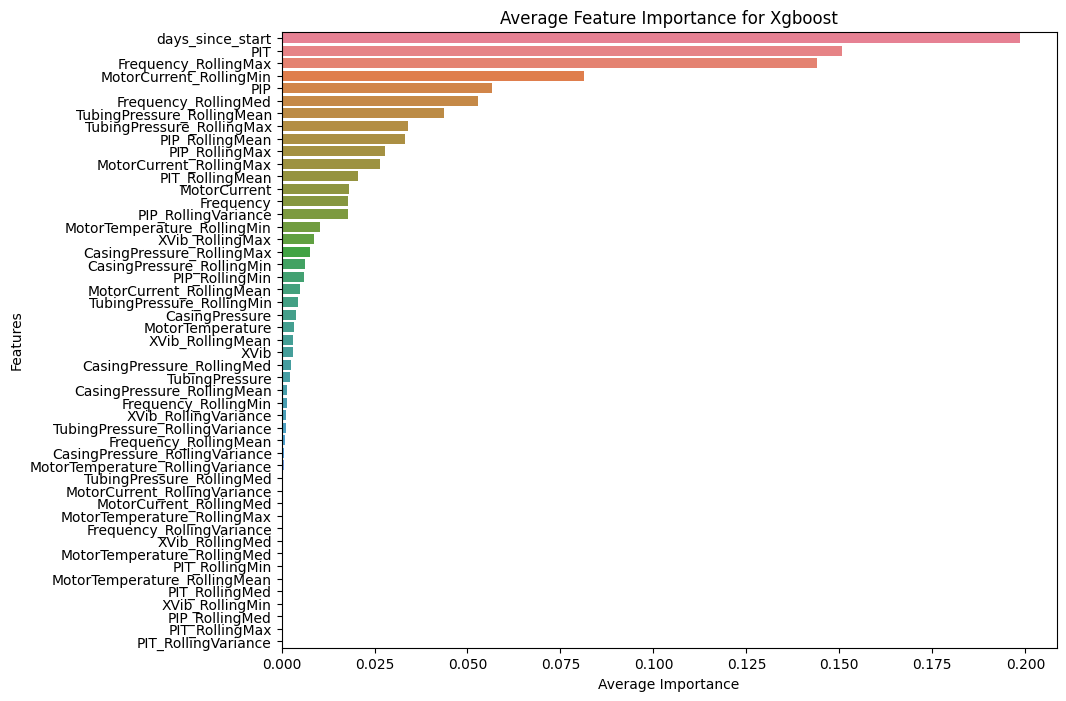

In [45]:
plt.figure(figsize=(10, 8))
sns.barplot(x=feature_importance['Average'], y=feature_importance.index, hue=feature_importance.index, legend=False)
plt.title('Average Feature Importance for Xgboost')
plt.xlabel('Average Importance')
plt.ylabel('Features')
plt.show()